<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_04_04_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06. 사이킷런으로 수행하는 타이타닉 생존자 예측**


In [6]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# 노트북 실행 화면에서 그림이 바로 보이도록 하는 코드

In [3]:
# 데이터 불러오기

from google.colab import drive
drive.mount('/content/drive')
titanic = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')
titanic.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# 데이터 정보
titanic.info()
# 5개의 column: object type (=string)
# age, cabin, embarked: 177,608,2 null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Null value 처리하기: fillna() function
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)
titanic['Cabin'].fillna('N', inplace=True)
titanic['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수: ', titanic.isnull().sum().sum())
# null value 남아있는지 확인

데이터 세트 Null 값 개수:  0


In [9]:
# feature 값 분류: Sex, Cabin, Embarked
print('Sex 값 분포: \n', titanic['Sex'].value_counts())
print('Cabin 값 분포: \n', titanic['Cabin'].value_counts())
print('Embarked 값 분포: \n', titanic['Embarked'].value_counts())

Sex 값 분포: 
 male      577
female    314
Name: Sex, dtype: int64
Cabin 값 분포: 
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
Embarked 값 분포: 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


- 분석 결과
      - N값이 687건으로 가장 많음
      - 속성값이 제대로 정리가 되지 않음
      - 선실 등급을 나타내는 첫 번째 알파벳이 중요해보임
      - 등급이 높을수록 생존확률이 더 높았을 것 

In [10]:
titanic['Cabin'] = titanic['Cabin'].str[:1]
print(titanic['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


### **1. 데이터 탐색**
#### **1) 생존 확률이 높은 승객 유형**
- 제1 구조 대상: 여성, 아이들, 노인
- 제2 구조 대상: 부자, 유명인

In [11]:
# 성별이 생존 확률에 미친 영향 파악하기
titanic.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

- 분석 결과
      - Survivied 0: 사망 / 1: 생존
      - 탑승객 수: 남자-577명 / 여자-314명
      - 생존자 수: 남자-109명 / 여자-233명
      - 생존률: 남자-18.8% / 여자-74.2%

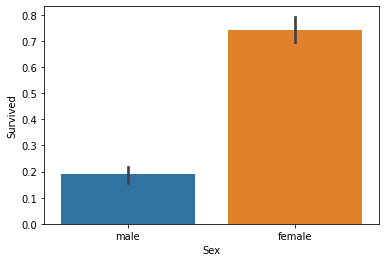

In [13]:
# 성별에 따른 생존률 그래프로 확인하기
sns.barplot(x='Sex', y='Survived', data=titanic)

#### **2) 경제능력에 따른 생존 확률**
- 부 측정 기준: 객실 등급
- 부와 함께 성별을 고려하여 생존률 확인

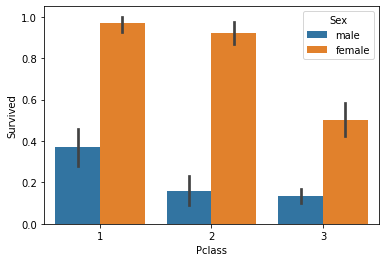

In [15]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic)

- **분석 결과**
      - 여성은 일,이등실에 따른 생존률 차이가 거의 없으나, 삼등실에서 차이가 많이 남
      - 남성은 전체적으로 생존률이 여성에 비해 낮고, 일등실 생존률이 이,삼등실에 비해 확연히 높음

#### **3) 나이에 따른 생존 확률**
- 값 종류가 많아 범위별로 분류하여 카테고리 값 할당
- Baby: 0~5세
- Child: 6~12세
- Teenager: 13~18세
- Student: 19~25세
- Young Adult: 26~35세
- Adult: 36~60세
- Elderly: 51세 이상

In [17]:
def get_category(age):
  cat = ''
  if age < -1: cat = "Unknown"
  elif age <= 5: cat = "Baby"
  elif age <=12: cat = "Child"
  elif age <=18: cat = "Teenager"
  elif age <=25: cat = "Student"
  elif age <=35: cat = "Young Adult"
  elif age <=60: cat = "Adult"
  else: cat = "Elderly"
  return cat

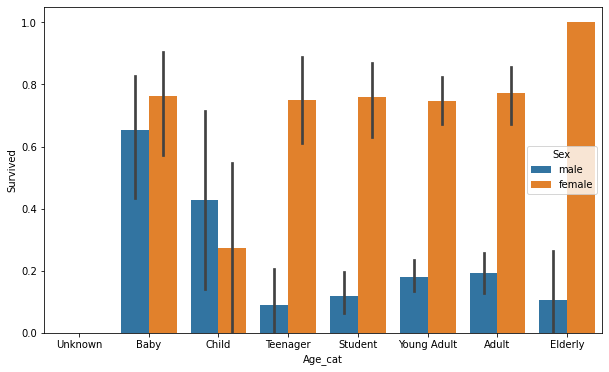

In [21]:
# 막대그래프 크기 figure 더 크게 설정
plt.figure(figsize = (10,6)) # figsize=(가로,세로)

# x축 값을 순차적으로 표시하기 위한 설정
group_names = ["Unknown","Baby","Child","Teenager","Student","Young Adult","Adult","Elderly"]

# lambda 식에서 생성한 get_category() function 반환값으로 지정
titanic['Age_cat'] = titanic['Age'].apply(lambda x: get_category(x))
sns.barplot(x="Age_cat", y="Survived", hue="Sex", data=titanic, order=group_names)
titanic.drop('Age_cat', axis = 1, inplace=True)

- **분석 결과**
      - 여성은 child을 제외하고 나머지 나이대에서 모두 매우 높은 생존률을 보임
      - 특히 female-elderly가 1.0에 가까운 생존률을 보임
      - 남성은 대체적으로 여성에 비해 많이 낮았으며, baby가 가장 생존률이 높음
      - *sex, pclass, age가 생존을 좌우하는 feature임을 확인함

In [23]:
# 다른 문자열 카테고리 feature -> 숫자형 카테고리 피처로 변환하기
# LabelEncoder: 0 ~ (category-1)까지 숫자로 값 변환
# fit(), transform(): 데이터 변환

from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])

  return dataDF

titanic = encode_features(titanic)
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3


In [11]:
# 지금까지 쓴 개념 함수로 나타내기

## 1. null 처리 함수
def fillna(titanic) : 
  titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)
  titanic['Cabin'].fillna('N', inplace=True)
  titanic['Embarked'].fillna('N', inplace=True)
  titanic['Fare'].fillna(0, inplace=True)
  return titanic

## 2. 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(titanic) :
  titanic.drop(['PassengerId', 'Name','Ticket'], axis=1, inplace=True)
  return titanic

## 3. 레이블 인코딩 수행
def format_features(titanic):
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features :
    le = preprocessing.LabelEncoder()
    le = le.fit(titanic[feature])
    titanic[feature] = le.transform(titanic[feature])
  return titanic
  
## 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(titanic) : 
  titanic = fillna(titanic)
  titanic = drop_features(titanic)
  titanic = format_features(titanic)
  return titanic

#### **4) 데이터 전처리 수행 함수로 다시 원본 데이터 가공하기**
- transform_features()
- Survived 속성을 드롭하여 feature dataset 생성

In [5]:
# 원본 데이터 재로딩
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
titanic = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
# feature dataset & label dataset 추출
y_titanic = titanic['Survived']
X_titanic = titanic.drop('Survived', axis=1)

X_titanic = transform_features(X_titanic)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic,
                                                  test_size=0.2, random_state=11)

- 결정 트리, 랜덤 포레스트, 로지스틱 회귀
- 사이킷런 기반
  - **결정 트리: DecisionTreeClassifier**
  - **랜덤 포레스트: RandomForestClassifier**
  - **로지스틱 회귀: LogisticRegression**
- 예측 성능 평가: 정확도
  - accuracy_score()


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
# 결정트리, 랜덤 포레스트, 로지스틱 회귀를 위한 사이킷런 classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(random_state=11)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7989
RandomForestClassifier 정확도: 0.8436
LogisticRegression 정확도: 0.8547


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- **분석 결과**
      - 3개 알고리즘 중에서 로지스틱 회귀가 높은 정확도를 나타냄
      - 하지만 최적화 작업도 안하고, 데이터 양도 충분하지 않기 때문에 알고리즘 성능 비교를 할 수 없음

- 교차 검증
  - **KFold()**
  - **cross_val_score()**
  - **GridSearchCV**

In [21]:
# KFold로 교차 검증하기

from sklearn.model_selection import KFold
import numpy as np

def exec_kfold(clf, folds=5):
  # fold set를 5개인 KFold 생성 & fold 수만큼 예측결과 저장을 위한 리스트 객체 생성
  kfold = KFold(n_splits=folds)
  scores = []

  # KFold 교차 검증 수행
  # enumerate(): 인덱스와 원소를 동시에 보여주는 함수

  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic)):
    # X_titanic 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic.values[train_index], X_titanic.values[test_index]
    y_train, y_test = y_titanic.values[train_index], y_titanic.values[test_index]

    # Classifier 학습, 예측, 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
  
  # 5개 fold에서 평균 정확도 계산
  mean_score =  np.mean(scores)
  print('평균 정확도: {0:.4f}'.format(mean_score))

# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7486
교차 검증 1 정확도: 0.7640
교차 검증 2 정확도: 0.8202
교차 검증 3 정확도: 0.7809
교차 검증 4 정확도: 0.7921
평균 정확도: 0.7812


In [22]:
# cross_val_score() 통해 교차 검증하기

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_train, y_train, cv=5)
for iter_count, accuracy in enumerate(scores):
  print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))

print('평균 정확도: {0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도: 0.7413
교차 검증 1 정확도: 0.7413
교차 검증 2 정확도: 0.7817
교차 검증 3 정확도: 0.7958
교차 검증 4 정확도: 0.7817
평균 정확도: 0.7683


- KFold와 cross_val_score 결과 비교
      - cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할하여 KFold의 정확도와 차이가 있음

In [24]:
# GridSearchCV로 교차 검증하기
# 최적 하이퍼 파라미터를 찾기 / 예측 성능 측정
## CV: 5개 폴드 지정
## 하.파는 max_depth, min_samples_split, min_sample_leaf변경하면서 성능 측정

from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2,3,5,10],
              'min_samples_split': [2,3,5],
              'min_samples_leaf': [1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring='accuracy',cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 :{0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
GridSearchCV 최고 정확도 :0.7993
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8659


- 분석 결과
      - 최적화된 파라미터: max_depth=5, min_samples_leaf = 1, min_samples_split=5
      - 예측 정확도가 87%로 향상됨